# Data collection

## [NASA Prediction of Worldwide Energy Resources (POWER)](https://aws.amazon.com/marketplace/pp/prodview-agetvmpkkzb7a?sr=0-1&ref_=beagle&applicationId=AWSMPContessa#resources)

In [35]:
'''
CODE BASED ON:
*Version: 1.0 Published: 2024/02/14* Source: [NASA POWER](https://power.larc.nasa.gov/)
POWER Remotely Connect to, Slice, and Download from a POWER Zarr via Python
This is an overview of the process to connect to and download from a POWER Zarr-formatted ARD via Python.
'''

import os
import fsspec

from datetime import datetime, timedelta

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import regionmask

import matplotlib.pyplot as plt

import folium
from folium import Rectangle


%matplotlib inline

In [36]:
# Time range for daily data
start_date = '2001-01-01'
# end_date = '2001-01-03'
# end_date = datetime.now().strftime('%Y-%m-%d')  # This sets the end date to today's date

# This sets the end date to today's date
today = datetime.now()

# Subtracting 14 days from today's date
end_date_minus_14_days = today - timedelta(days=14)

# Converting to string in 'YYYY-MM-DD' format
end_date = end_date_minus_14_days.strftime('%Y-%m-%d')

# Geographic range covering Uganda and Kenya
lat_range = (-4.5, 19)  # South to North
lon_range = (22.5, 52)  # West to East

# Filepaths for different meteorological datasets with their corresponding variables
filepaths = {
    'https://power-analysis-ready-datastore.s3.us-west-2.amazonaws.com/power_901_daily_meteorology_utc.zarr': [
        'PRECTOTCORR', 'EVPTRNS', 'T2M', 'TS', 'PS', 'WS2M', 'WS10M', 'QV2M', 'RH2M', 'GWETROOT', 'GWETPROF', 'GWETTOP'
    ],
    'https://power-analysis-ready-datastore.s3.us-west-2.amazonaws.com/power_901_daily_precipitation_utc.zarr': [
        'PRECIPITATIONCAL'
    ],
    'https://power-analysis-ready-datastore.s3.us-west-2.amazonaws.com/power_901_daily_radiation_utc.zarr': [
        'CLOUD_AMT', 'ALLSKY_SFC_SW_DWN'
    ]
}


In [37]:
def load_and_process_datasets(filepaths: dict, start_date: str, end_date: str, lat_range: tuple, lon_range: tuple) -> list:
    """
    Loads and processes multiple datasets from a dictionary of Zarr stores, selecting specific variables and slicing according to specified time, latitude, and longitude ranges.

    Parameters:
    - filepaths (dict): Dictionary with URLs to the Zarr stores as keys and lists of variable names as values.
    - start_date (str): Start date in the format YYYY-MM-DD.
    - end_date (str): End date in the format YYYY-MM-DD.
    - lat_range (tuple): Latitude range (start, end).
    - lon_range (tuple): Longitude range (start, end).

    Returns:
    - list: A list of xarray Datasets containing the selected and sliced data from each filepath.
    """
    datasets = []
    for filepath, variables in filepaths.items():
        filepath_mapped = fsspec.get_mapper(filepath)
        ds = xr.open_zarr(filepath_mapped, consolidated=True)
        ds_selected_all = {}
        
        for variable in variables:
            print(f"Downloading {variable} from {filepath}...")
            if variable in ds.data_vars:  # Ensure the variable exists in the dataset
                ds_selected_all[variable] = ds[variable].sel(
                    time=pd.date_range(start=start_date, end=end_date, freq='D'),
                    lat=slice(*lat_range),
                    lon=slice(*lon_range)
                ).load()

        if ds_selected_all:
            ds_combined = xr.Dataset(ds_selected_all)
            datasets.append(ds_combined)
    
    return datasets

In [39]:
# Load and process each dataset by specifying filepaths and variables
datasets = load_and_process_datasets(filepaths, start_date, end_date, lat_range, lon_range)

In [40]:
def visualize_area(lat_range, lon_range):
    """
    Visualizes a specified area on a map using Folium.

    Parameters:
    - lat_range (tuple): A tuple of (min_latitude, max_latitude) for the area.
    - lon_range (tuple): A tuple of (min_longitude, max_longitude) for the area.

    Returns:
    - A Folium Map object centered around the midpoint of the specified area with a rectangle overlay of the area.
    """
    # Calculate the center of the area
    center_lat = (lat_range[0] + lat_range[1]) / 2
    center_lon = (lon_range[0] + lon_range[1]) / 2

    # Create a Folium map centered around the calculated midpoint
    map_centered = folium.Map(location=[center_lat, center_lon], zoom_start=6)

    # Define the bounds of the rectangle for the specified area
    bounds = [(lat_range[0], lon_range[0]), (lat_range[1], lon_range[1])]

    # Create a rectangle overlay and add it to the map
    folium.Rectangle(bounds=bounds, color='#ff7800', fill=True, fill_opacity=0.2).add_to(map_centered)

    # Display the map
    return map_centered

In [41]:
# Visualize the area
map_visualization = visualize_area(lat_range, lon_range)

# To display the map in a Jupyter Notebook, simply call the map object
map_visualization

In [42]:
import xarray as xr

def merge_xarray_datasets(datasets, lat_step, lon_step):
    """
    Merges multiple xarray datasets after interpolating them to a common grid defined only by step sizes for latitude and longitude.
    The function calculates the latitude and longitude bounds based on the extent of the datasets provided.

    Parameters:
    - datasets (list of xarray.Dataset): List of datasets to merge.
    - lat_step (float): Step size for latitude.
    - lon_step (float): Step size for longitude.

    Returns:
    - xarray.Dataset: A single dataset merged from the input datasets on the common grid.
    """
    # Determine the min and max of latitude and longitude from all datasets
    lat_min = min(ds.lat.min() for ds in datasets)
    lat_max = max(ds.lat.max() for ds in datasets)
    lon_min = min(ds.lon.min() for ds in datasets)
    lon_max = max(ds.lon.max() for ds in datasets)

    # Generate target latitude and longitude arrays
    target_lat = np.arange(lat_min, lat_max + lat_step, lat_step)
    target_lon = np.arange(lon_min, lon_max + lon_step, lon_step)

    interpolated_datasets = []
    
    for ds in datasets:
        # Interpolate dataset to the target grid
        ds_interp = ds.interp(lat=target_lat, lon=target_lon, method='linear')
        interpolated_datasets.append(ds_interp)

    # Combine all datasets along the time dimension (or other dimensions as needed)
    merged_dataset = xr.concat(interpolated_datasets, dim='time', coords='minimal', compat='override')
    
    return merged_dataset

# Example usage
# Assume datasets is your list of xarray Datasets
# lat_step = 0.5    # 0.5 degree latitude step
# lon_step = 0.625  # 0.625 degree longitude step
# merged_ds = merge_xarray_datasets(datasets, lat_step, lon_step)


In [43]:
lat_step = 0.5    # 0.5 degree latitude step
lon_step = 0.625  # 0.625 degree longitude step
merged_ds = merge_xarray_datasets(datasets, lat_step, lon_step)
del datasets

In [48]:
merged_ds

<xarray.Dataset> Size: 7GB
Dimensions:            (time: 25491, lat: 48, lon: 49)
Coordinates:
  * time               (time) datetime64[ns] 204kB 2001-01-01 ... 2024-04-06
  * lat                (lat) float64 384B -4.5 -4.0 -3.5 -3.0 ... 18.0 18.5 19.0
  * lon                (lon) float64 392B 22.5 23.12 23.75 ... 51.25 51.88 52.5
Data variables: (12/15)
    PRECTOTCORR        (time, lat, lon) float64 480MB 4.287e-05 ... nan
    EVPTRNS            (time, lat, lon) float64 480MB 107.1 96.77 ... nan nan
    T2M                (time, lat, lon) float64 480MB 296.8 296.9 ... nan nan
    TS                 (time, lat, lon) float64 480MB 296.5 296.7 ... nan nan
    PS                 (time, lat, lon) float64 480MB 9.503e+04 ... nan
    WS2M               (time, lat, lon) float64 480MB 0.2344 0.2344 ... nan nan
    ...                 ...
    GWETROOT           (time, lat, lon) float64 480MB 0.5234 0.625 ... nan nan
    GWETPROF           (time, lat, lon) float64 480MB 0.5312 0.6328 ... nan nan
    GWETTOP            (time, lat, lon) float64 480MB 0.6094 0.6953 ... nan nan
    PRECIPITATIONCAL   (time, lat, lon) float64 480MB nan nan nan ... nan nan
    CLOUD_AMT          (time, lat, lon) float64 480MB nan nan nan ... nan nan
    ALLSKY_SFC_SW_DWN  (time, lat, lon) float64 480MB nan nan nan ... nan nan

In [44]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

def plot_lat_lon_grids_with_borders(ds, time_index=0, variable=None, zoom_factor=1):
    """
    Plots the lat/lon grid points of an xarray.Dataset on a map with country borders,
    for a given time index, and dynamically adjusts the zoom to the dataset's area.
    Grid points are colored from a palette based on their index.

    Parameters:
    - ds (xarray.Dataset): The input dataset.
    - time_index (int): The time index to plot. Defaults to the first time index (0).
    - variable (str): The name of the variable to plot. If None, only the grid points will be plotted.
    - zoom_factor (float): A multiplier to adjust the map's zoom level. Default is 1 for no adjustment.

    Example of usage:
    - plot_lat_lon_grids_with_borders(masked_dataset, time_index=0, variable='CDD0')
    """
    # Determine the extent based on the dataset's latitude and longitude
    lat_min, lat_max = np.min(ds.lat.values), np.max(ds.lat.values)
    lon_min, lon_max = np.min(ds.lon.values), np.max(ds.lon.values)
    
    # Apply zoom factor
    lat_range = (lat_max - lat_min) * zoom_factor
    lon_range = (lon_max - lon_min) * zoom_factor
    mid_lat = (lat_max + lat_min) / 2
    mid_lon = (lon_max + lon_min) / 2
    extent = [mid_lon - lon_range/2, mid_lon + lon_range/2, mid_lat - lat_range/2, mid_lat + lat_range/2]

    # Create the figure and axis with a PlateCarree projection
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Add geographical features
    ax.add_feature(cfeature.BORDERS)
    ax.coastlines()

    # Plot the variable if specified
    if variable is not None and variable in ds.data_vars:
        im = ax.pcolormesh(ds.lon.values, ds.lat.values, ds[variable].isel(time=time_index),
                           shading='auto', transform=ccrs.PlateCarree(), cmap='viridis')
        plt.colorbar(im, ax=ax, shrink=0.5, label=variable)

    # Plot grid points
    lon2d, lat2d = np.meshgrid(ds.lon.values, ds.lat.values)
    num_points = lon2d.size
    colors = plt.cm.viridis(np.linspace(0, 1, num_points))

    plt.title(f'{variable if variable else "Grid Points"} at Time Index {time_index}')
    plt.show()

# Example call to function with additional arguments if needed
# plot_lat_lon_grids_with_borders(dataset, time_index=0, variable='CDD0', zoom_factor=1.5)


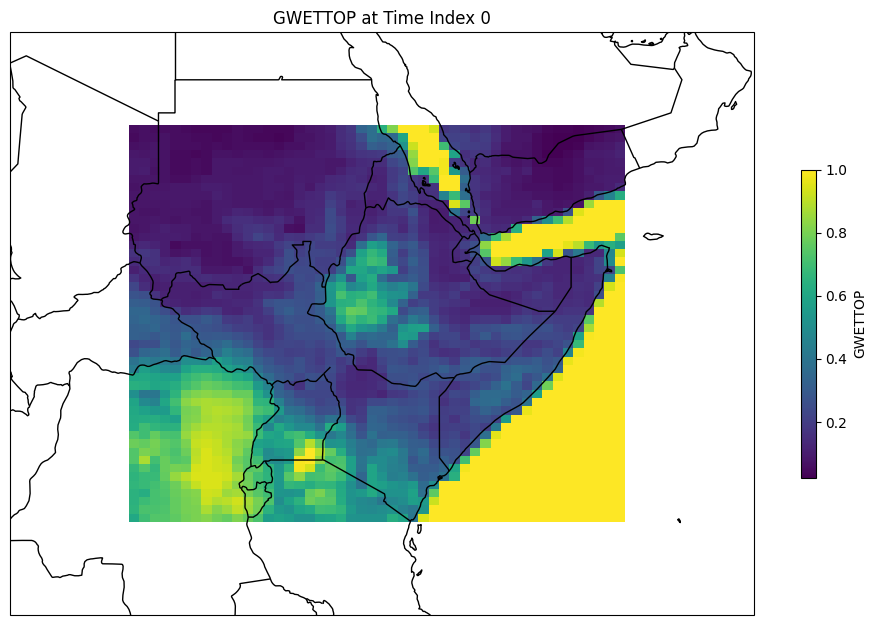

In [45]:
plot_lat_lon_grids_with_borders(merged_ds, time_index=0, variable='GWETTOP', zoom_factor=1.5)

In [46]:
# # Define compression settings
# compression_opts = {'zlib': True, 'complevel': 5}  # You can adjust the compression level from 1 to 9

# # Apply the compression to each variable in the dataset
# encoding = {var: compression_opts for var in masked_dataset.variables}

# # Export the region as a compressed NetCDF4 file
# merged_ds.to_netcdf(
#     path=os.path.join("/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/01_raw/power_nasa_data.nc"),
#     encoding=encoding
# )


In [47]:
merged_ds.to_netcdf("/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/01_raw/power_nasa_data.nc")